<a href="https://colab.research.google.com/github/ss-shankar/ml-onlineretail-clustering/blob/main/onlineretail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library and Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

# Dataset Describtion


In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
df.shape

(541909, 8)

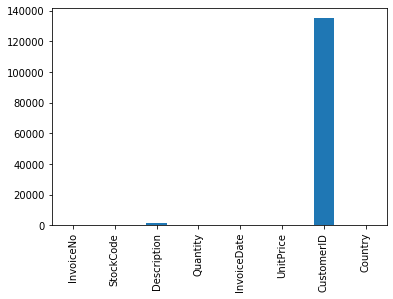

In [ ]:
df.isna().sum().plot(kind='bar')

In [ ]:
df.dropna(inplace=True)

In [ ]:
df['Total Amount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df_customer_amount = df.groupby('CustomerID')['Total Amount'].sum()

In [ ]:
df_customer_amount = df_customer_amount.reset_index()

In [ ]:
df_customer_amount.shape

(4372, 2)

In [ ]:
df_customer_freq = df.groupby('CustomerID')['InvoiceNo'].count()

In [ ]:
df_customer_freq = df_customer_freq.reset_index()

In [ ]:
df_customer_freq.shape

(4372, 2)

In [ ]:
max_date = max(df['InvoiceDate'])

In [ ]:
df['recent purchase'] = max_date - df['InvoiceDate']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Amount,recent purchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [ ]:
df_customer_recent = df.groupby('CustomerID')['recent purchase'].min()

In [ ]:
df_customer_recent = df_customer_recent.reset_index()

In [ ]:
import datetime as dt

In [ ]:
df_customer_recent.head()

,CustomerID,recent purchase
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [ ]:
df_customer_recent['recent purchase'] = df_customer_recent['recent purchase'].dt.days

In [ ]:
df_customer_recent.head()

,CustomerID,recent purchase
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [ ]:
df_merge1 = df_customer_amount.merge(df_customer_freq, on=['CustomerID'])

In [ ]:
df_merge1.shape

(4372, 3)

In [ ]:
df_merge_final = df_merge1.merge(df_customer_recent, on=['CustomerID'])

In [ ]:
df_merge_final.shape

(4372, 4)

In [ ]:
df_merge_final.head()

,CustomerID,Total Amount,InvoiceNo,recent purchase
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [ ]:
numeric_variable = ['Total Amount', 'InvoiceNo', 'recent purchase']

In [ ]:
for i in numeric_variable :
  q1 = df_merge_final[i].quantile(0.05)
  q3 = df_merge_final[i].quantile(0.95)
  iqr = q3 - q1
  df_merge_final = df_merge_final[(df_merge_final[i] >= q1 - 1.5*iqr) & (df_merge_final[i] <= q3 + 1.5*iqr)]

In [ ]:
df_merge_final.shape

(4293, 4)

In [ ]:
from sklearn.preprocessing import StandardScaler
scc = StandardScaler()

In [ ]:
scaled = scc.fit_transform(df_merge_final[numeric_variable])

In [ ]:
scaled.shape

(4293, 3)

In [ ]:
df_scaled = pd.DataFrame(scaled)
df_scaled.columns=numeric_variable

In [ ]:
df_scaled.head()

,Total Amount,InvoiceNo,recent purchase
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
scores = []
for i in range(2,7):
  kmeans=KMeans(n_clusters=i, max_iter=40, verbose=True).fit(df_scaled)
  scores.append(kmeans.inertia_)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 7722.818690494112
start iteration
done sorting
end inner loop
Iteration 1, inertia 7678.186525187327
start iteration
done sorting
end inner loop
Iteration 2, inertia 7669.361412451805
start iteration
done sorting
end inner loop
Iteration 3, inertia 7663.8757517489685
start iteration
done sorting
end inner loop
Iteration 4, inertia 7662.401842040968
start iteration
done sorting
end inner loop
Iteration 5, inertia 7662.045027971662
start iteration
done sorting
end inner loop
Iteration 6, inertia 7661.939943472988
center shift 6.361301e-05 within tolerance 1.000000e-04
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 9671.045370237263
start iteration
done sorting
end inner loop
Iteration 1, inertia 8061.175647885685
start iteration
done sorting
end inner loop
Iteration 2, inertia 7848.183268446708
start iteration
done sorting
end inner loop
Iteration 3, inertia 

In [ ]:
len(scores)

5

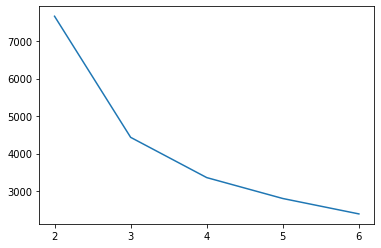

In [ ]:
plt.plot(range(2,7,1), scores)
plt.xticks(ticks=range(2,7))
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
for i in range(2,7) :
  kmeans = KMeans(n_clusters=i, max_iter=40).fit(df_scaled)
  cluster_labels = kmeans.labels_
  silhouette_avg = silhouette_score(df_scaled, cluster_labels)
  print('For n_cluster{} the silhouette score is {}'.format(i, silhouette_avg))

For n_cluster2 the silhouette score is 0.5415858652525395
For n_cluster3 the silhouette score is 0.5084896296141937
For n_cluster4 the silhouette score is 0.4817567985759693
For n_cluster5 the silhouette score is 0.4662700564189704
For n_cluster6 the silhouette score is 0.41753051875511704


In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=50).fit(df_scaled)
clusters = kmeans.labels_

In [ ]:
df_merge_final['Cluster'] = clusters

In [ ]:
df_merge_final.head()

,CustomerID,Total Amount,InvoiceNo,recent purchase,Cluster
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0
